# Tables illustration of working with computational models of probability

## David Culler

This notebook seeks to illustrate simple datascience.Table operations as part of a basic lesson on probability.

Documentation on the datascience module is at [http://data8.org/datascience/index.html](http://data8.org/datascience/index.html) and of Tables as [http://data8.org/datascience/tables.html](http://data8.org/datascience/tables.html).

In [1]:
# HIDDEN - generic nonsense for setting up environment
from datascience import *
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
from ipywidgets import interact
# datascience version number of last run of this notebook
version.__version__

/usr/local/lib/python3.6/dist-packages/datascience/tables.py:17: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/usr/local/lib/python3.6/dist-packages/datascience/util.py:10: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


'0.10.6'

## Create a table as a model of a stochastic phenomenom

Here we create a single column table as a computational model of a die
with each element of the table containing the number of dots on the side.
This illustrates the simplest way of constructing a table, [`Table.with_column`](http://data8.org/datascience/_autosummary/datascience.tables.Table.with_column.html#datascience.tables.Table.with_column).

Then we define a function that models rolling a die.  This illustrates the
use of [`Table.sample`](http://data8.org/datascience/_autosummary/datascience.tables.Table.sample.html#datascience.tables.Table.sample)
to take random sample of a table.

In [2]:
die = Table().with_column('side', [1,2,3,4,5,6])
die

side
1
2
3
4
5
6


In [9]:
# Simulate the roll of a die by sampling from the die table
def roll_die():
    return die.sample(1)['side'][0]

In [8]:
# roll it.  Try this over and over and see what you get
roll_die()

3

## Composition

Build a computational model of rolling a die many times using our `roll_die` function as a building block.  It happens to utilize tables internally, but we have abstracted away from that.  Here it is a *black box* that yields a random roll of a die.  Again, we create a table to model the result.

In [12]:
# Simulate rolling it many times, creating a table that records the rolls
num_rolls = 600
rolls = Table().with_column('roll', [roll_die() for i in range(num_rolls)])
rolls

roll
5
3
1
3
3
3
4
4
2
2


## Visualization

Above we see just the tip of the table.  And, of course, it would be tedious to look at all those rolls.  Instead, we want to look at some *descriptive statistics* of the process.  We can do that with [`Table.hist`](http://data8.org/datascience/_autosummary/datascience.tables.Table.hist.html#datascience.tables.Table.hist), which
can be used to produce a histogram or a discrete distribution (the default, i.e., `normed = True`).

The histogram of the rolls shows what we mean by 'uniform at random'.  All sides are equally likely to come up on each roll.  Thus the number of times each comes up in a large number of rolls is nearly constant.  But not quite.
The rolls table it self won't change on its own, but every time you run the cell above, you will get a slightly different picture.

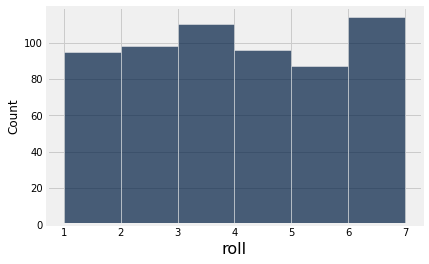

In [13]:
bins = np.arange(1,8)
rolls.hist(bins=bins, normed=False)

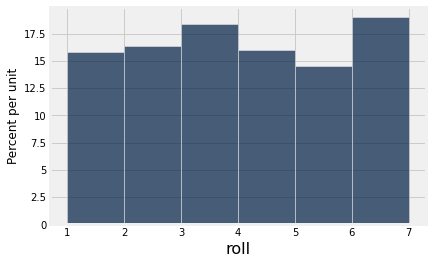

In [14]:
# Normalize this gives a distribution.  The probability of each side appearing.  1/6.
rolls.hist(normed=True,bins=bins)

## Computing on distributions

While visualization is useful for humans in the data exploration process, everything you see you should be able to compute upon.  The analog of `Table.hist` that yields a table, rather than a chart is [`table.bin`](http://data8.org/datascience/_autosummary/datascience.tables.Table.bin.html#datascience.tables.Table.bin).  It returns a new table with a row for each bin.

Here we also illustrate doing some computing on the distribution table:
* A column of a table is accessed using the standard python *get* syntax: `<object> [ <key> ]`. This actually yields an object that is a [numpy array](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html), but part of the beauty of tables is you don't have to worry about what that is. The beauty of numpy arrays is that you can work with them pretty much like values, i.e., you can scale them by a constant, add them together and things like that.
* A column is inserted in the table using the standard python set syntax for objects `<object> [ <key> ] = <value>`. Note that this modifies the table, adding a column if it does not exist ro updating it if it does.  The transformations on tables are *functional*, they produce new tables.  Set treats a table like an object and modifies it.

In [16]:
roll_dist = rolls.bin(normed=True,bins=bins).take(range(6))
roll_dist

bin,roll density
1,0.158333
2,0.163333
3,0.183333
4,0.16
5,0.145
6,0.19


In [17]:
roll_dist['roll density']

array([0.15833333, 0.16333333, 0.18333333, 0.16      , 0.145     ,
       0.19      ])

In [18]:
roll_dist['Variation'] = (roll_dist['roll density'] - 1/6)/(1/6)
roll_dist

bin,roll density,Variation
1,0.158333,-0.05
2,0.163333,-0.02
3,0.183333,0.1
4,0.16,-0.04
5,0.145,-0.13
6,0.19,0.14


In [19]:
# What is the average value of a roll?
sum(roll_dist['bin']*roll_dist['roll density'])

3.54

In [20]:
np.mean(rolls['roll'])

3.54

## Statistical thinking

They say "life is about rolling dice".  The statistical perspective on the `rolls` table above would be captured by sampling many times from the die table.  We can capture than naturally in a computational abstraction that rolls a die `n` times.

In [22]:
# Life is about rolling lots of dice.
# Simulate rolling n dice.
def roll(n):
    """Roll n die.  Return a table of the rolls"""
    return die.sample(n, with_replacement=True)

In [23]:
# try it out.  many times
roll(10)

side
1
6
4
4
6
4
5
6
5
4


## Interactive visualization

The central concept of computational thinking - *abstraction*. Here it is illustrated again by wrapping up the process of rolling many die and visualizing the resulting distribution into a function.

Once we have it as a function, we can illustrate the central concept of inferential thinking - *the law of large numbers* - through interactive visualization.  When a dies is rolled only a few times, the resulting distribution may be very uneven.  But when it is rolled many many times, it is extremely rare for the result to be uneven.

In [24]:
def show_die_dist(n):
    """Roll a die n times and show the distribution of sides that appear."""
    roll(n).hist(bins=np.arange(1,8))

In [25]:
# We can now use the ipywidget we had included at the beginning.
interact(show_die_dist, n=(10, 1000, 10))

interactive(children=(IntSlider(value=500, description='n', max=1000, min=10, step=10), Output()), _dom_classe…

<function __main__.show_die_dist>

## Likelihood

If we really roll the dice several times in life, what might we expect the overall outcome to be like?

We can extend our computational approach further by simulating the rolling of several die many many times. 

In [ ]:
num_die = 10

In [ ]:
num_rolls = 100

In [ ]:
# Remember - referencing a column gives an array
roll(num_die)['side']

In [ ]:
# Simulate rolling num_die dice num_rolls times and build a table of the result
rolls = Table(["die_"+str(i) for i in range(num_die)]).with_rows([roll(num_die)['side'] for i in range(num_rolls)])
rolls

In [ ]:
# If we think of each row as a life experience, what is the life like?
label = "{}_dice".format(num_die)
sum_rolls = Table().with_column(label, [np.sum(roll(num_die)['side']) for i in range(num_rolls)])
sum_rolls.hist(range=[10,6*num_die], normed=False)
sum_rolls.stats()

In [ ]:
# Or as a distribution
sum_rolls.hist(range=[10,6*num_die],normed=True)

In [ ]:
# Or normalize by the number of die ...
#
Table().with_column(label, [np.sum(roll(num_die)['side'])/num_die for i in range(num_rolls)]).hist(normed=False)

In probability theory, the central limit theorem (CLT) states that, given certain conditions, the arithmetic mean of a sufficiently large number of iterates of independent random variables, each with a well-defined expected value and well-defined variance, will be approximately normally distributed, regardless of the underlying distribution.